**<h2>Facial Keypoints Detection</h2>**
**<h4>Detect the location of keypoints on face images</h4>**

Github Repo: https://github.com/se7ensecondz/facial-keypoints-detection

**<h3>Problem and Data Description</h3>**

When performing task like facial recognition, it would be too computationally expensive if we use all the details captured by a camera. Normally, the process would use the most important features to identify a human face, and we call them "facial keypoints". Detecting these "facial keypoints" is a very challenging task because every individual has facial features that are greatly different from others, and even for the same person there can be lots of variations caused by different combinations of pose, facial expression, camera angle and lighting effects etc. Accurate facial keypoints detection is super useful in building other applications, including tracking faces in images and video, analyzing facial expressions/signs for medical diagnosis, or enhancing public security monitoring etc. This is a typical deep learning problem that can be solved using technique like Convolutional Neural Network(CNN). This is also a regression problem as we are going to predict coordinate values of the facial keypoints that have minimal root mean squared error(RMSE). Now let's dive into the dataset and build some effective models to tackle down this challenging problem.

**<h3>Exploratory Data Analysis</h3>**

As usual, let's import the necessary libraries first and then start off by performing some data explorations and analysis. We will use PyTorch as the framework to build our custom CNN, and I also imported pre-trained ResNet model from PyTorch for a fun model comparison in the later section.

In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.models import resnet50, ResNet50_Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # utilize GPU for training if available

Configure working directory for loading data.

In [2]:
base_dir = "."

train_zip = os.path.join(base_dir, "training.zip")
test_zip = os.path.join(base_dir, "test.zip")
id_lookup = os.path.join(base_dir, "IdLookupTable.csv")

df_train = pd.read_csv(train_zip, compression="zip")
df_test = pd.read_csv(test_zip, compression="zip")
df_id = pd.read_csv(id_lookup)

In [3]:
print(f"Number of train images: ", len(df_train))
print(f"Number of test images: ", len(df_test))

Number of train images:  7049
Number of test images:  1783


There are 7,049 train images, and 1,783 test images in total.

In [4]:
print(f"Number of columns: {len(df_train.columns)}\n")
for col in df_train.columns:
    print(col)

Number of columns: 31

left_eye_center_x
left_eye_center_y
right_eye_center_x
right_eye_center_y
left_eye_inner_corner_x
left_eye_inner_corner_y
left_eye_outer_corner_x
left_eye_outer_corner_y
right_eye_inner_corner_x
right_eye_inner_corner_y
right_eye_outer_corner_x
right_eye_outer_corner_y
left_eyebrow_inner_end_x
left_eyebrow_inner_end_y
left_eyebrow_outer_end_x
left_eyebrow_outer_end_y
right_eyebrow_inner_end_x
right_eyebrow_inner_end_y
right_eyebrow_outer_end_x
right_eyebrow_outer_end_y
nose_tip_x
nose_tip_y
mouth_left_corner_x
mouth_left_corner_y
mouth_right_corner_x
mouth_right_corner_y
mouth_center_top_lip_x
mouth_center_top_lip_y
mouth_center_bottom_lip_x
mouth_center_bottom_lip_y
Image


As we can see, except `Image` column, we have 15 facial keypoints: `left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip`, and (x, y) coordinate values for each keypoint, making them 30 columns in total.

In [5]:
print(df_train["Image"].dtype)

object


In [6]:
for img in df_train["Image"]:
    assert len(img.split(" ")) == 9216 == 96 * 96
print(f"Image data is complete.")

Image data is complete.


The type of `Image` column is string, each string consists of 9,216 integers (pixel values from 0 to 255) concatenated by a space, representing a `96 x 96` image.

Let's display the distribution of facial keypoints and see what they look like.

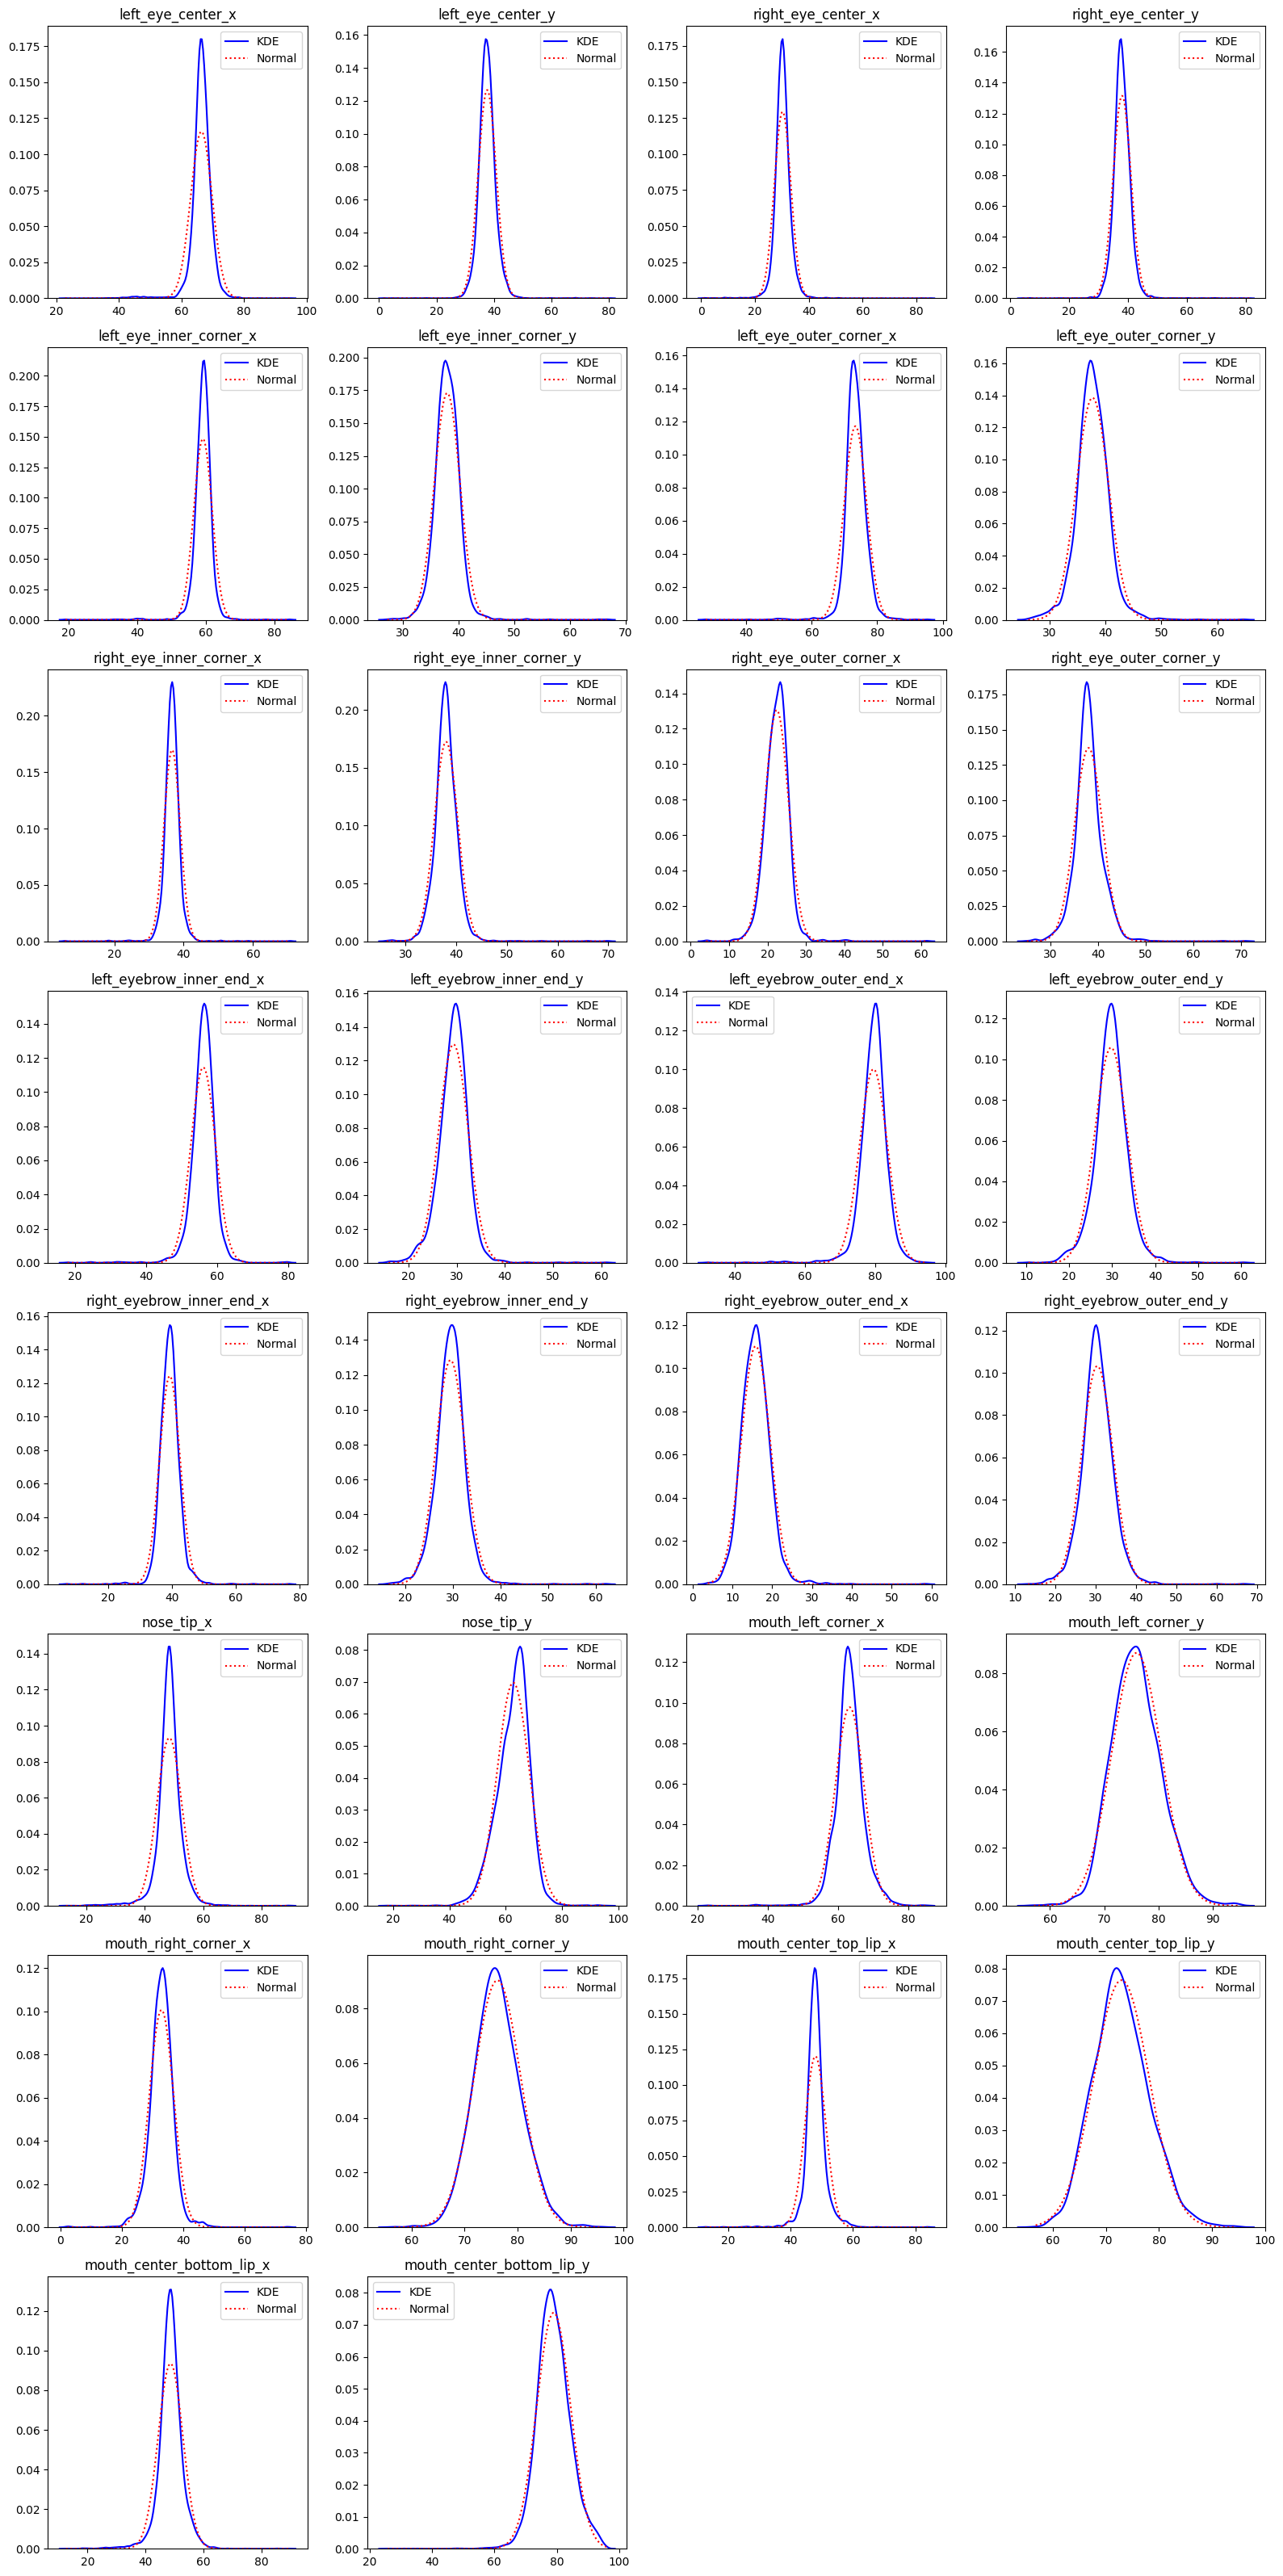

In [7]:
def display_facial_keypoints_distribution():
    nrows = 8
    ncols = 4
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 32))
    axes = axes.flatten()
    cols = [c for c in df_train.columns if c != "Image"]
    for ax, col in zip(axes, cols):
        data = df_train[col].dropna()
        sns.kdeplot(data, ax=ax, color="b", label="KDE")
        vals = np.linspace(data.min(), data.max(), 500)
        pdf = norm.pdf(vals, loc=data.mean(), scale=data.std())
        ax.plot(vals, pdf, color="r", linestyle=":", label="Normal")
        ax.set_title(col, fontsize=12)
        ax.legend(fontsize=10)
        ax.set_xlabel("")
        ax.set_ylabel("")
    for i in range(len(cols), len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

display_facial_keypoints_distribution()

Some keypoints follow a nearly normal distribution, for example `right_eyebrow_outer_end_x`, `mouth_left_corner_y` and `mouth_right_corner_y`, while many others follow a leptokurtic distribution (with higher peak and heavier tails), indicating that they could have more outliers and more data clustered around the mean.

Next, let's examine if there is any missing value in our dataset.

In [8]:
# check missing values
miss_count = df_train.isnull().sum()
miss_ratio = round(miss_count / len(df_train) * 100, 2)
miss_df = pd.DataFrame({
    "Missing Count": miss_count,
    f"Missing Percent(total:{len(df_train)})": miss_ratio
})
print(miss_df)

                           Missing Count  Missing Percent(total:7049)
left_eye_center_x                     10                         0.14
left_eye_center_y                     10                         0.14
right_eye_center_x                    13                         0.18
right_eye_center_y                    13                         0.18
left_eye_inner_corner_x             4778                        67.78
left_eye_inner_corner_y             4778                        67.78
left_eye_outer_corner_x             4782                        67.84
left_eye_outer_corner_y             4782                        67.84
right_eye_inner_corner_x            4781                        67.83
right_eye_inner_corner_y            4781                        67.83
right_eye_outer_corner_x            4781                        67.83
right_eye_outer_corner_y            4781                        67.83
left_eyebrow_inner_end_x            4779                        67.80
left_eyebrow_inner_e

Many keypoints have lots of missing values (67-68% are missing), dropping them may not be ideal as we will simply lose more than half of the training data. From the previous keypoints distributions we learned that many of them have extreme values/outliers, since median is more robust than mean when dealing with outliers, I'll go ahead and fill the missing values with column median.

In [9]:
df_train = df_train.fillna(df_train.median(numeric_only=True))
print(f"Number of missing values now:", sum(df_train.isnull().sum()))

Number of missing values now: 0


Next, let's process the `Image` column to convert them to numpy array, and also create x_train (image) and y_train (facial keypoints) data for training.

In [10]:
H, W, C = 96, 96, 1 # the image has a height and width of 96, and a single grayscale channel

# construct x_train
x_train = []
for i in range(len(df_train)):
    image = np.array(df_train["Image"][i].split(" "), dtype=np.float32)
    # reshape to height * width * channel for image display, will convert to channel * height * width for pytorch
    image = np.reshape(image, (H, W, C))
    x_train.append(image)
x_train = np.array(x_train) / 255.0

# construct x_test
x_test = []
for i in range(len(df_test)):
    image = np.array(df_test["Image"][i].split(" "), dtype=np.float32)
    # reshape to channel * height * width for pytorch
    image = np.reshape(image, (C, H, W))
    x_test.append(image)
x_test = np.array(x_test) / 255.0

# construct y_train
df_fkp = df_train.drop("Image", axis=1)
y_train = [df_fkp.iloc[i,:].values for i in range(len(df_fkp))]
y_train = np.array(y_train, dtype=np.float32)

print(f"Shape of x_train: {(x_train.shape)}")
print(f"Shape of x_test: {(x_test.shape)}")
print(f"Shape of y_train: {(y_train.shape)}")

Shape of x_train: (7049, 96, 96, 1)
Shape of x_test: (1783, 1, 96, 96)
Shape of y_train: (7049, 30)


Let's display some random human face images, first without facial keypoints, and second include facial keypoints for comparison.

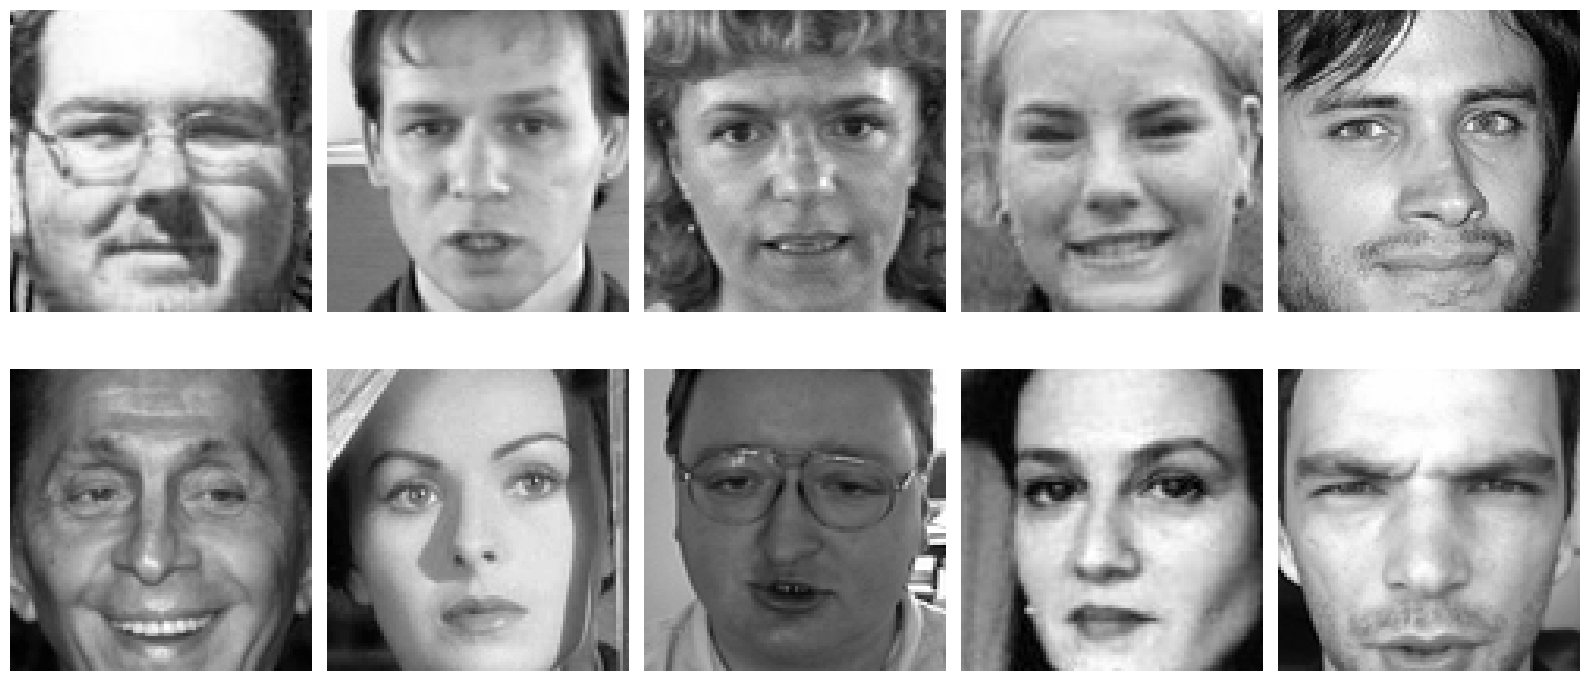

In [11]:
def display_images(ax, idx, include_facial_keypoints=False):
    ax.imshow(x_train[idx], cmap="gray")
    if include_facial_keypoints:
        # (x, y) for 15 facial features, 30 in total
        i = 0
        while i < 30:
            x, y = y_train[idx][i], y_train[idx][i + 1]
            ax.plot(x, y, marker=".", color="red")
            i += 2
    ax.axis('off')

nrows = 2
ncols = 5
random.seed(42)
samples = random.sample(range(len(x_train)), nrows * ncols)

# without facial keypoints
_, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))
for ax, idx in zip(axes.flatten(), samples):
    display_images(ax, idx, include_facial_keypoints=False)
plt.tight_layout()
plt.show()

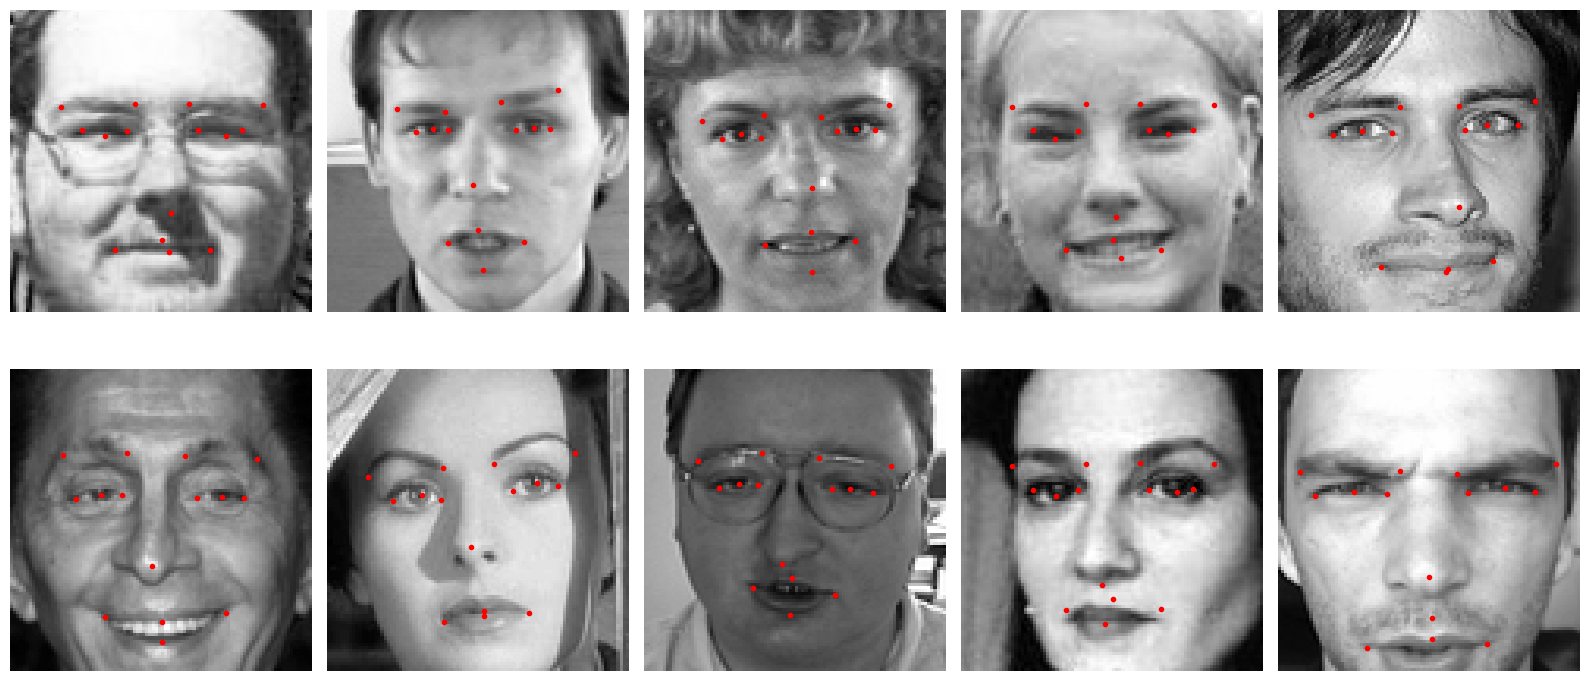

In [12]:
# with facial keypoints
_, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))
for ax, idx in zip(axes.flatten(), samples):
    display_images(ax, idx, include_facial_keypoints=True)
plt.tight_layout()
plt.show()

In this EDA section, we analyzed input data size, meaning of columns, facial keypoints distributions, and also interpolated missing values with median. Next let's build and train some CNN models.

**<h3>Building Custom CNN Model and Trainer</h3>**

Now, let's build our custom convolutional neural network from scratch using PyTorch for training the input images, and predicting the coordinates of the 15 facial keypoints. This model consists of 8 convolutional layers, 3 pooling layers for image training, and linear layers for producing continuous output values.

Additionally, I will also create a `ModelTrainer` that contains necessary functions for training, validation and display loss/rmse trend over epochs, which we can reuse to plug in a different model and compare them easily.

In [13]:
class FacialKeypointsCustomCNN(nn.Module):
    def __init__(self, chans=32, dropout_rate=0.2):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.conv = self._build_conv(chans)
        with torch.no_grad():
            dummy_tensor = torch.zeros(1, 1, 96, 96)
            flatten_size = self.conv(dummy_tensor).view(1, -1).size(1)
        # Output layer to produce 30 continuous values
        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_rate),
            nn.Linear(512, 30)
        )

    # Create a convolutional layer block
    def _build_conv_block(self, in_chans, out_chans, use_dropout=False):
        seq = [
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1, bias=False)
        ]
        if use_dropout:
            seq.append(nn.Dropout(self.dropout_rate))
        seq.append(nn.BatchNorm2d(out_chans))
        seq.append(nn.LeakyReLU(0.1, inplace=True))
        return nn.Sequential(*seq)

    # Create convolutional layers
    def _build_conv(self, chans):
        seq = []
        seq.append(self._build_conv_block(1, chans, use_dropout=False))
        seq.append(self._build_conv_block(chans, chans, use_dropout=False))
        seq.append(nn.MaxPool2d(2, 2))
        
        seq.append(self._build_conv_block(chans, chans * 2, use_dropout=True))
        seq.append(self._build_conv_block(chans * 2, chans * 2, use_dropout=True))
        seq.append(nn.MaxPool2d(2, 2))
        
        seq.append(self._build_conv_block(chans * 2, chans * 4, use_dropout=True))
        seq.append(self._build_conv_block(chans * 4, chans * 4, use_dropout=True))
        seq.append(nn.MaxPool2d(2, 2))
        
        seq.append(self._build_conv_block(chans * 4, chans * 8, use_dropout=True))
        seq.append(self._build_conv_block(chans * 8, chans * 8, use_dropout=True))
        return nn.Sequential(*seq)

    def forward(self, x):
        x = self.conv(x)
        return self.output(x)


In [14]:
class ModelTrainer:
    def __init__(self, model, batch_size, lr, betas, x_train=x_train, y_train=y_train):
        self.model = model.to(device)
        self.batch_size = batch_size
        self.lr = lr
        self.betas = betas
        self.train_data_loader, self.val_data_loader = self._get_data_loaders(x_train, y_train)
        self.loss_fn = nn.MSELoss()
        self.optimizer = Adam(self.model.parameters(), lr=self.lr, betas=self.betas)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", factor=0.5, patience=5)
        self.history = {
            "train_loss": [],
            "train_rmse": [], 
            "val_loss": [],
            "val_rmse": [],
        }

    def _get_data_loaders(self, x_train, y_train):
        # convert to channel * height * width for pytorch
        x = np.transpose(x_train, (0, 3, 1, 2))
        y = y_train
        dataset = TensorDataset(
            torch.from_numpy(x).float(),
            torch.from_numpy(y).float(),
        )
        train_size = int(len(dataset) * 0.8)
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        train_data_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_data_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        return train_data_loader, val_data_loader

    def _train_epoch(self):
        # train a single epoch
        self.model.train()
        L = 0.0
        SQ_ERR = 0.0
        N = 0
        for x, y in self.train_data_loader:
            x = x.to(device)
            y = y.to(device)
            # update optimizer, total loss and sq_err
            self.optimizer.zero_grad()
            pred = self.model(x)
            loss = self.loss_fn(pred, y)
            loss.backward()
            self.optimizer.step()
            n = x.size(0)
            L += loss.item() * n
            SQ_ERR += torch.sum((pred - y) ** 2).item()
            N += n
        train_loss = L / N
        train_rmse = (SQ_ERR / N) ** 0.5
        return train_loss, train_rmse

    def _validate_epoch(self):
        # validate a single epoch
        self.model.eval()
        L = 0.0
        SQ_ERR = 0.0
        N = 0
        with torch.no_grad():
            for x, y in self.val_data_loader:
                x = x.to(device)
                y = y.to(device)
                # update total loss and sq_err
                pred = self.model(x)
                loss = self.loss_fn(pred, y)
                n = x.size(0)
                L += loss.item() * n
                SQ_ERR += torch.sum((pred - y) ** 2).item()
                N += n
        val_loss = L / N
        val_rmse = (SQ_ERR / N) ** 0.5
        return val_loss, val_rmse

    def fit(self, epochs):
        # train/validate for specified number of epochs, dynamically 
        # adjust learning rate, and record history of MSE loss and RMSE
        print(f"Initial lr={self.lr:.3e}\n")
        print(f"beta1={self.betas[0]}\n")
        print(f"beta2={self.betas[1]}\n")
        for epoch in range(1, epochs + 1):
            train_loss, train_rmse = self._train_epoch()
            val_loss, val_rmse = self._validate_epoch()
            self.scheduler.step(val_loss)
            self.history["train_loss"].append(train_loss)
            self.history["train_rmse"].append(train_rmse)
            self.history["val_loss"].append(val_loss)
            self.history["val_rmse"].append(val_rmse)
            print(
                f"Epoch {epoch}/{epochs} (lr={self.optimizer.param_groups[0]["lr"]:.3e}):\t"
                f"train_loss={train_loss:.3f}, train_rmse={train_rmse:.3f}\t|\t"
                f"val_loss={val_loss:.3f}, val_rmse={val_rmse:.3f}"
            )

    def display_history(self):
        fig, axes = plt.subplots(2, 1, figsize=(16, 16))
        # Display MSE Loss across epochs
        ax0 = axes[0]
        ax0.plot(self.history["train_loss"], label="Train MSE Loss")
        ax0.plot(self.history["val_loss"], label="Validation MSE Loss")
        ax0.set_xlabel("Epoch")
        ax0.set_ylabel("MSE Loss")
        ax0.set_title("Train vs. Validation MSE Loss")
        ax0.legend()
        # Display RMSE across epochs
        ax1 = axes[1]
        ax1.plot(self.history["train_rmse"], label="Train RMSE")
        ax1.plot(self.history["val_rmse"], label="Validation RMSE")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("RMSE")
        ax1.set_title("Train vs. Validation RMSE")
        ax1.legend()
        fig.tight_layout()
        plt.show()


**<h3>Model Training and Hyperparameters Tuning</h3>**

Now let's use the `ModelTrainer` to train our `FacialKeypointsCustomCNN`. There are many hyperparameters we can choose to optimize, in my training I mainly focused on the following three:

- **Learning Rate**: We know that when the learning rate is too high, the weight updates in each epoch can be overly large, and cause the optimizer to jump over minima instead of converging gradually, while if the learning rate is too low, the weight updates are so tiny that it takes very long time to learn, and risks getting stuck at local minima and not able to reach a good solution. Therefore, I chose to use PyTorch's `ReduceLROnPlateau`, which dynamically updates learning rate when a metric has stopped improving. This way the model continuously adjust learning rate as we train, so we don't have to spend time finding the "one-size-fits-all" learning rate. The initial learning rate is set to `0.0002`.

- **Betas(beta1, beta2)**: These 2 values control how quickly the running averages of the first and second moments decay. I started with beta1=0.5 and beta2=0.9, and observed a bouncy trending in MSE loss, especially in validation. This indicates the beta values are too low, after a few retries with higher values, the optimal betas I could find is `beta1=0.9` and `beta2=0.999`. Although there are still some bounces at the beginning, the loss starts to decrease gradually and stably after the first few iterations.

- **Batch Size**: The `batch_size` in DataLoader represents the number of samples processed together in one step. From my experiments, I observed that batch_size can greatly affects the model performance. I started with a fairly large batch_size of 64 and observed that the MSE loss decrease was slow, and it had a hard time to further improve when it got around 11. This is a signal of batch_size being too large since the input image size is small. I then used 32 in the second experiment and saw some obvious improvements, the loss was lowered to around 8 and then stuck again. After a few more iterations, the optimal batch_size turned out to be `8` in our case, and I didn't see any significant gains in batch_size lower than that.

Initial lr=2.000e-04

beta1=0.9

beta2=0.999

Epoch 1/50 (lr=2.000e-04):	train_loss=55.818, train_rmse=40.921	|	val_loss=244.380, val_rmse=85.624
Epoch 2/50 (lr=2.000e-04):	train_loss=17.906, train_rmse=23.177	|	val_loss=27.240, val_rmse=28.586
Epoch 3/50 (lr=2.000e-04):	train_loss=14.738, train_rmse=21.027	|	val_loss=5.930, val_rmse=13.338
Epoch 4/50 (lr=2.000e-04):	train_loss=13.458, train_rmse=20.093	|	val_loss=5.211, val_rmse=12.503
Epoch 5/50 (lr=2.000e-04):	train_loss=12.671, train_rmse=19.497	|	val_loss=6.257, val_rmse=13.700
Epoch 6/50 (lr=2.000e-04):	train_loss=11.588, train_rmse=18.645	|	val_loss=4.557, val_rmse=11.692
Epoch 7/50 (lr=2.000e-04):	train_loss=10.890, train_rmse=18.074	|	val_loss=4.309, val_rmse=11.370
Epoch 8/50 (lr=2.000e-04):	train_loss=10.322, train_rmse=17.597	|	val_loss=4.616, val_rmse=11.768
Epoch 9/50 (lr=2.000e-04):	train_loss=10.268, train_rmse=17.551	|	val_loss=4.055, val_rmse=11.030
Epoch 10/50 (lr=2.000e-04):	train_loss=9.924, train_rmse=17.254	|	val

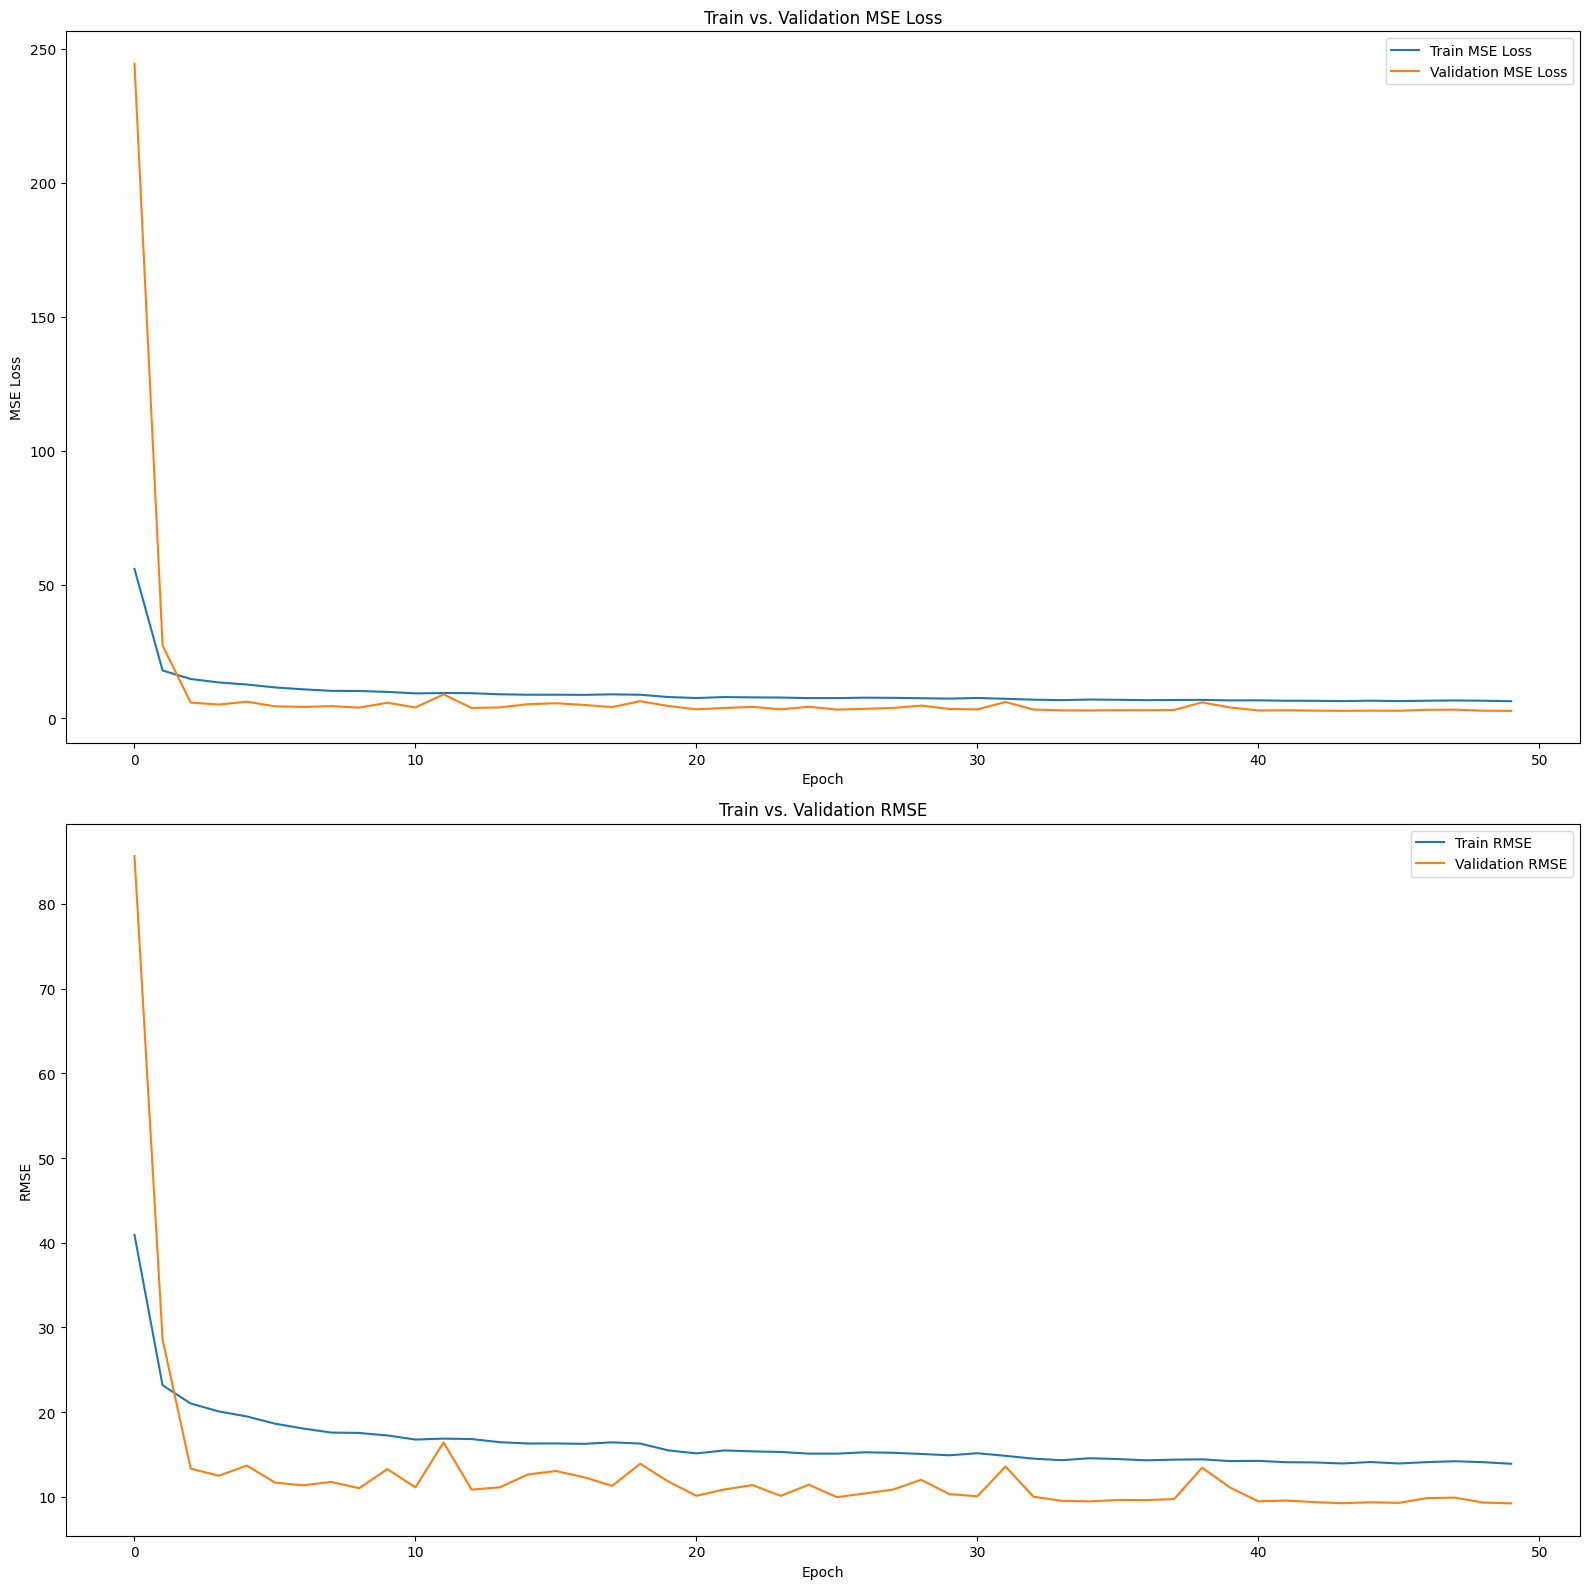

In [15]:
# Hyperparameters
epochs = 50
learning_rate = 0.0002
beta1 = 0.9
beta2 = 0.999
batch_size = 8

# Train a FacialKeypointsCustomCNN
fkp_custom_cnn_trainer = ModelTrainer(
    model=FacialKeypointsCustomCNN(),
    batch_size=batch_size,
    lr=learning_rate,
    betas=(beta1, beta2)
)
fkp_custom_cnn_trainer.fit(epochs=epochs)
fkp_custom_cnn_trainer.display_history()

The evaluation is based on Root Mean Squared Error (RMSE), the lower score is better.
- Tune1: batch_size=64, beta1=0.5, beta2=0.9
- Tune2: batch_size=16, beta1=0.9, beta2=0.999
- Tune3: batch_size=8, beta1=0.9, beta2=0.999

![Alt text](./tunings-screenshot.png)

Let's display some test images with predicted facial keypoints and see if they are accurate.

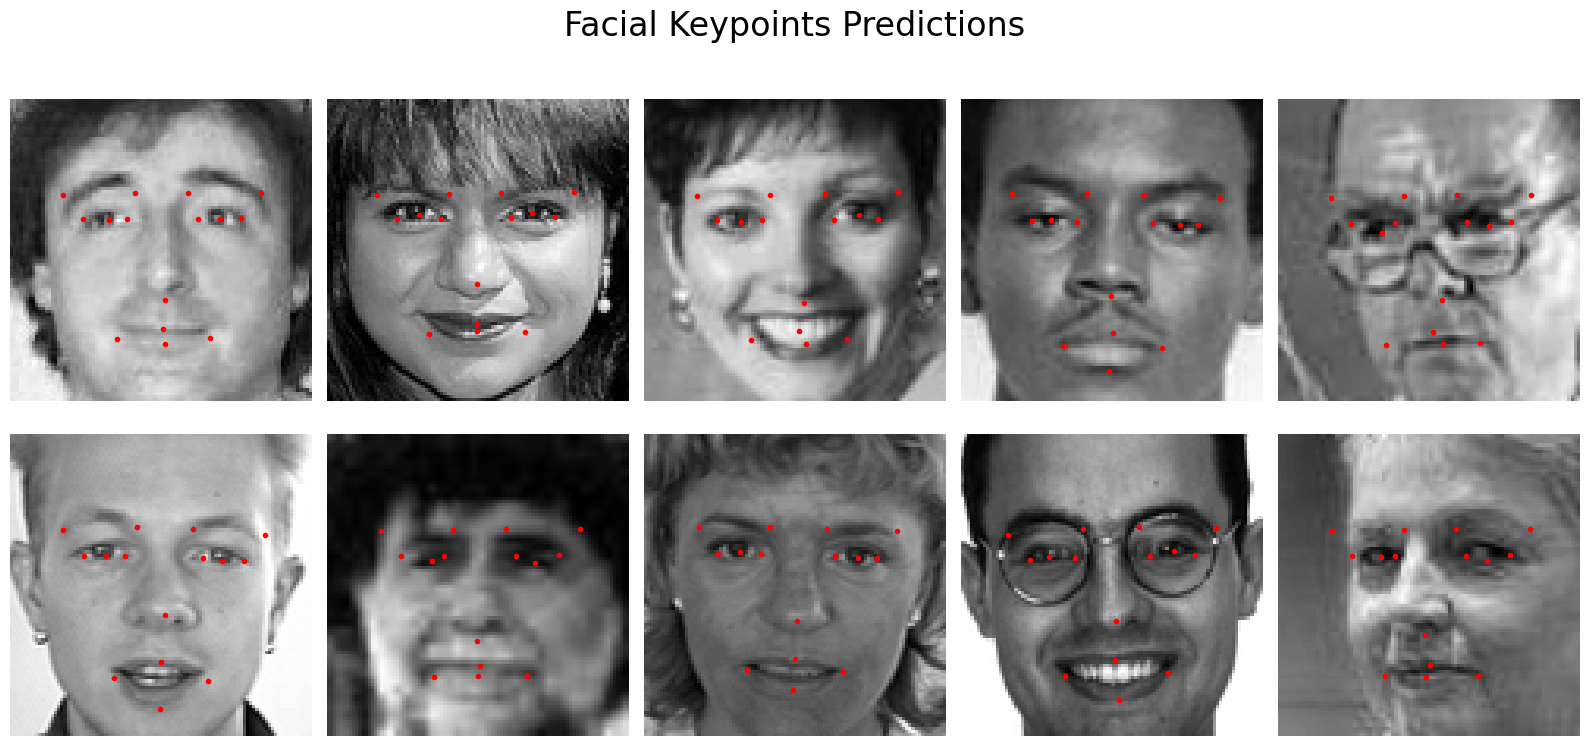

In [16]:
def display_facial_keypoints_predictions(model):
    nrows=2
    ncols=5
    random.seed(128)
    samples = random.sample(range(len(x_test)), nrows * ncols)
    images = x_test[samples]
    images_tensor = torch.from_numpy(images).float().to(device)

    model.eval()
    with torch.no_grad():
        pred = model(images_tensor).cpu().numpy()

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))
    axes = axes.flatten()
    for idx, ax in enumerate(axes):
        img = images[idx, 0, :, :]
        ax.imshow(img, cmap="gray")
        i = 0
        while i < 30:
            x, y = pred[idx][i], pred[idx][i + 1]
            ax.plot(x, y, marker=".", color="red")
            i += 2
        ax.axis("off")
    fig.suptitle("Facial Keypoints Predictions", fontsize=24)
    plt.tight_layout()
    plt.show()

display_facial_keypoints_predictions(fkp_custom_cnn_trainer.model)

As we can see, our custom CNN model predicted facial keypoints locations pretty accurately, especially for the front-facing images; while for side-view images, some keypoints can be slightly off.

**<h3>Models Comparison</h3>**

In the above section we train a custom CNN that we built from scratch for this problem. As a fun model comparison, in this section I'll train a pre-trained ResNet50 model and compare it against our custom model. A ResNet50 is an implementation of the famous residual network architecture that consists of 50 layers, making it a very powerful and efficient network for generic image processing tasks.

In [17]:
class FacialKeypointsResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        # Use pre-trained ResNet50
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self._update_conv1()
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.output = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, 30)
        )

    def _update_conv1(self):
        # Default first ResNet50 conv layer is built for RGB scale images,
        # we need to adjust a bit for training gray scale images.
        default_conv1 = self.resnet.conv1
        updated_conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=default_conv1.out_channels,
            kernel_size=default_conv1.kernel_size,
            stride=default_conv1.stride,
            padding=default_conv1.padding,
            bias=default_conv1.bias,
        )
        with torch.no_grad():
            # use averaged weight across all color channels
            avg_weight = default_conv1.weight.mean(dim=1, keepdim=True)
            updated_conv1.weight.copy_(avg_weight)
        self.resnet.conv1 = updated_conv1

    def forward(self, x):
        x = self.resnet(x)
        return self.output(x)


Initial lr=2.000e-04

beta1=0.9

beta2=0.999

Epoch 1/50 (lr=2.000e-04):	train_loss=145.418, train_rmse=66.049	|	val_loss=254.851, val_rmse=87.439
Epoch 2/50 (lr=2.000e-04):	train_loss=13.911, train_rmse=20.428	|	val_loss=540.266, val_rmse=127.311
Epoch 3/50 (lr=2.000e-04):	train_loss=11.907, train_rmse=18.900	|	val_loss=10.497, val_rmse=17.745
Epoch 4/50 (lr=2.000e-04):	train_loss=10.520, train_rmse=17.765	|	val_loss=10.202, val_rmse=17.494
Epoch 5/50 (lr=2.000e-04):	train_loss=9.561, train_rmse=16.936	|	val_loss=6.873, val_rmse=14.359
Epoch 6/50 (lr=2.000e-04):	train_loss=8.582, train_rmse=16.046	|	val_loss=5.211, val_rmse=12.503
Epoch 7/50 (lr=2.000e-04):	train_loss=8.152, train_rmse=15.639	|	val_loss=9.059, val_rmse=16.485
Epoch 8/50 (lr=2.000e-04):	train_loss=7.910, train_rmse=15.405	|	val_loss=4.435, val_rmse=11.535
Epoch 9/50 (lr=2.000e-04):	train_loss=7.430, train_rmse=14.930	|	val_loss=8.207, val_rmse=15.691
Epoch 10/50 (lr=2.000e-04):	train_loss=7.406, train_rmse=14.906	|	val

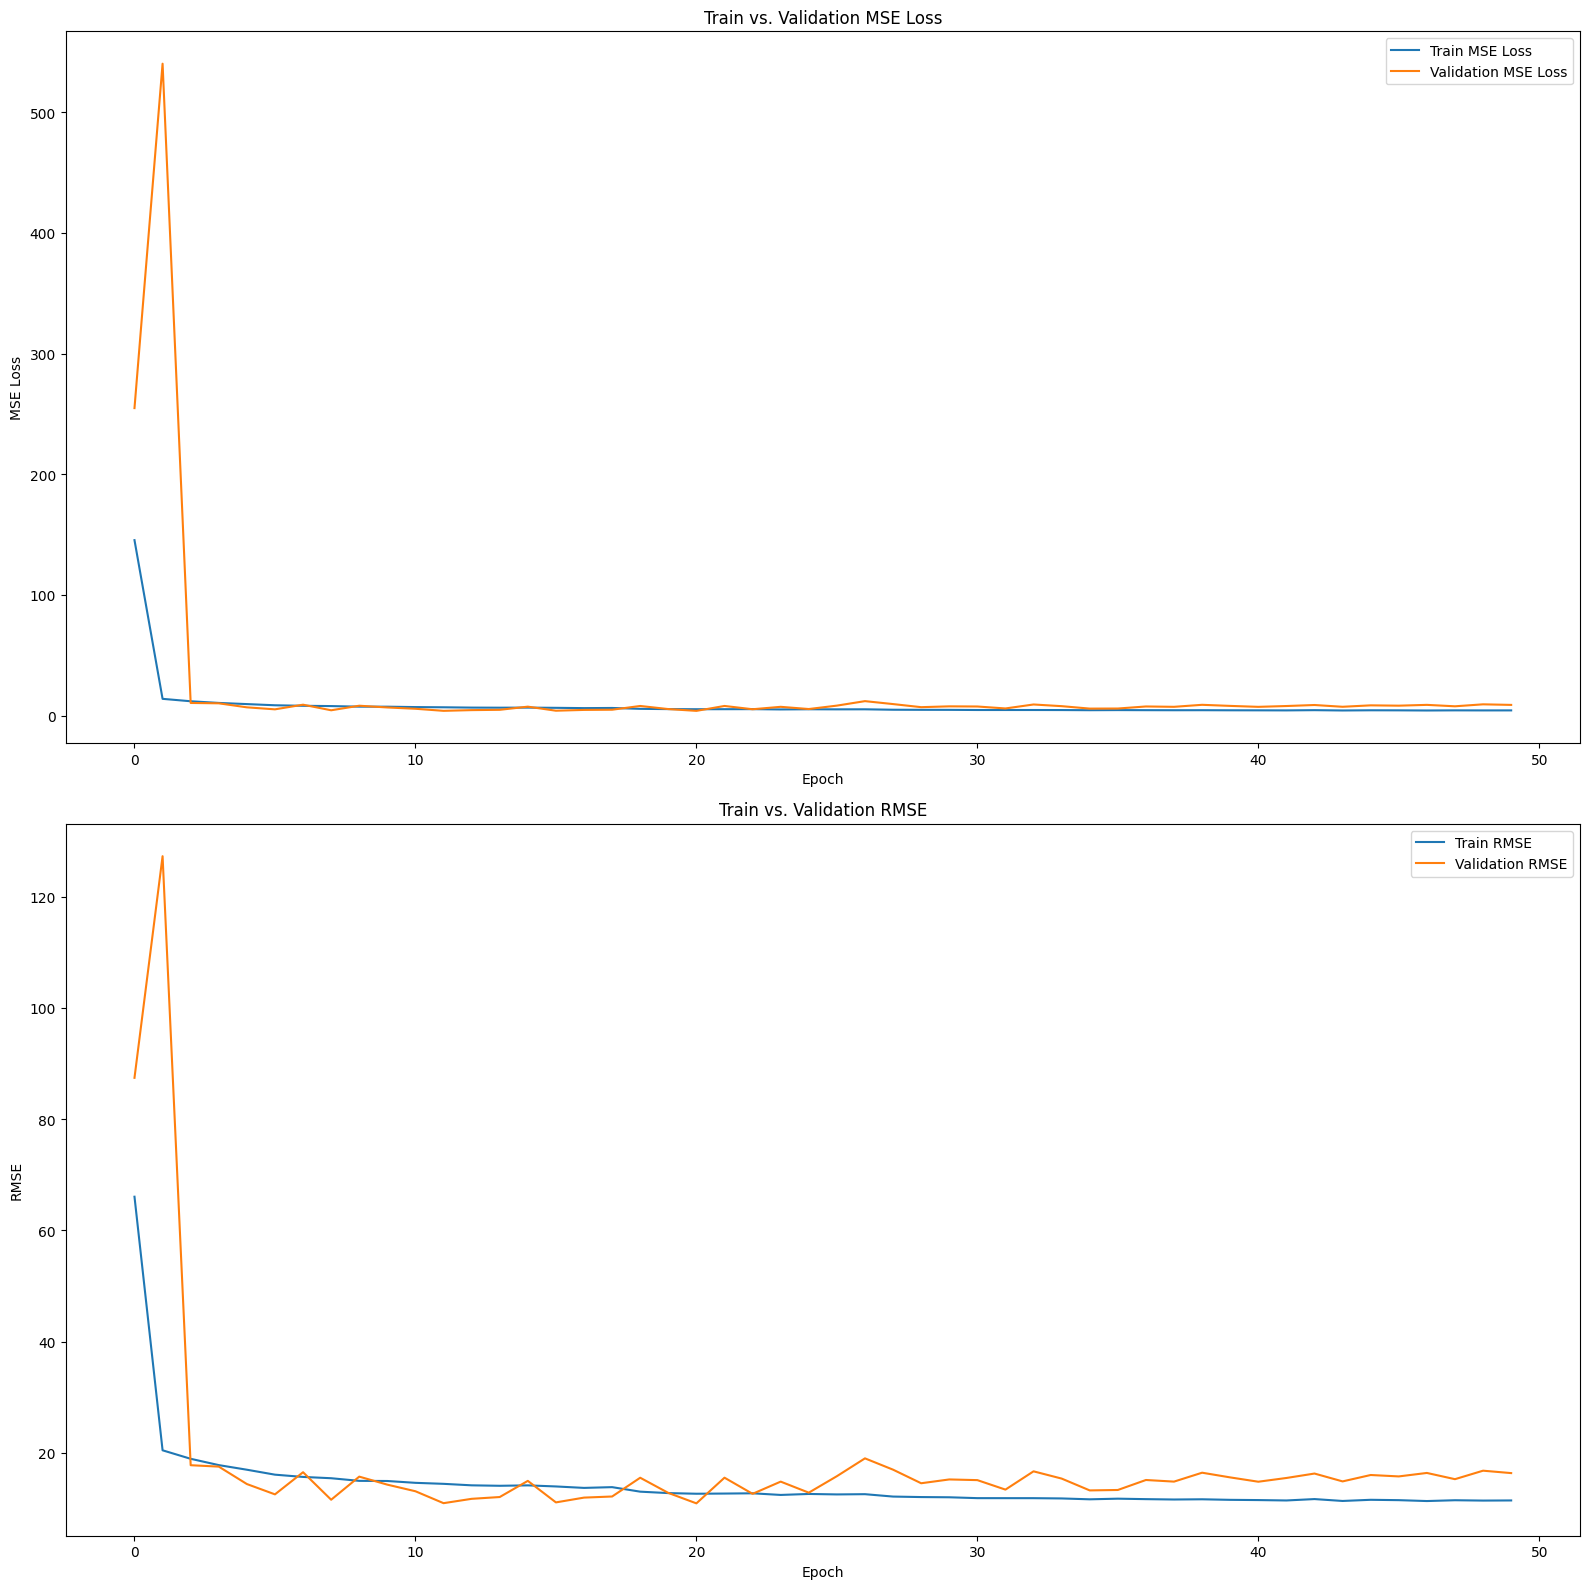

In [18]:
fkp_resnet50_trainer = ModelTrainer(
    model=FacialKeypointsResNet50(),
    batch_size=batch_size,
    lr=learning_rate,
    betas=(beta1, beta2)
)
fkp_resnet50_trainer.fit(epochs=epochs)
fkp_resnet50_trainer.display_history()

The model using ResNet50 as core resulted in an even better score.

![Alt text](./resnet50-screenshot.png)

Let's display some test images with predicted facial keypoints using ResNet50 model.

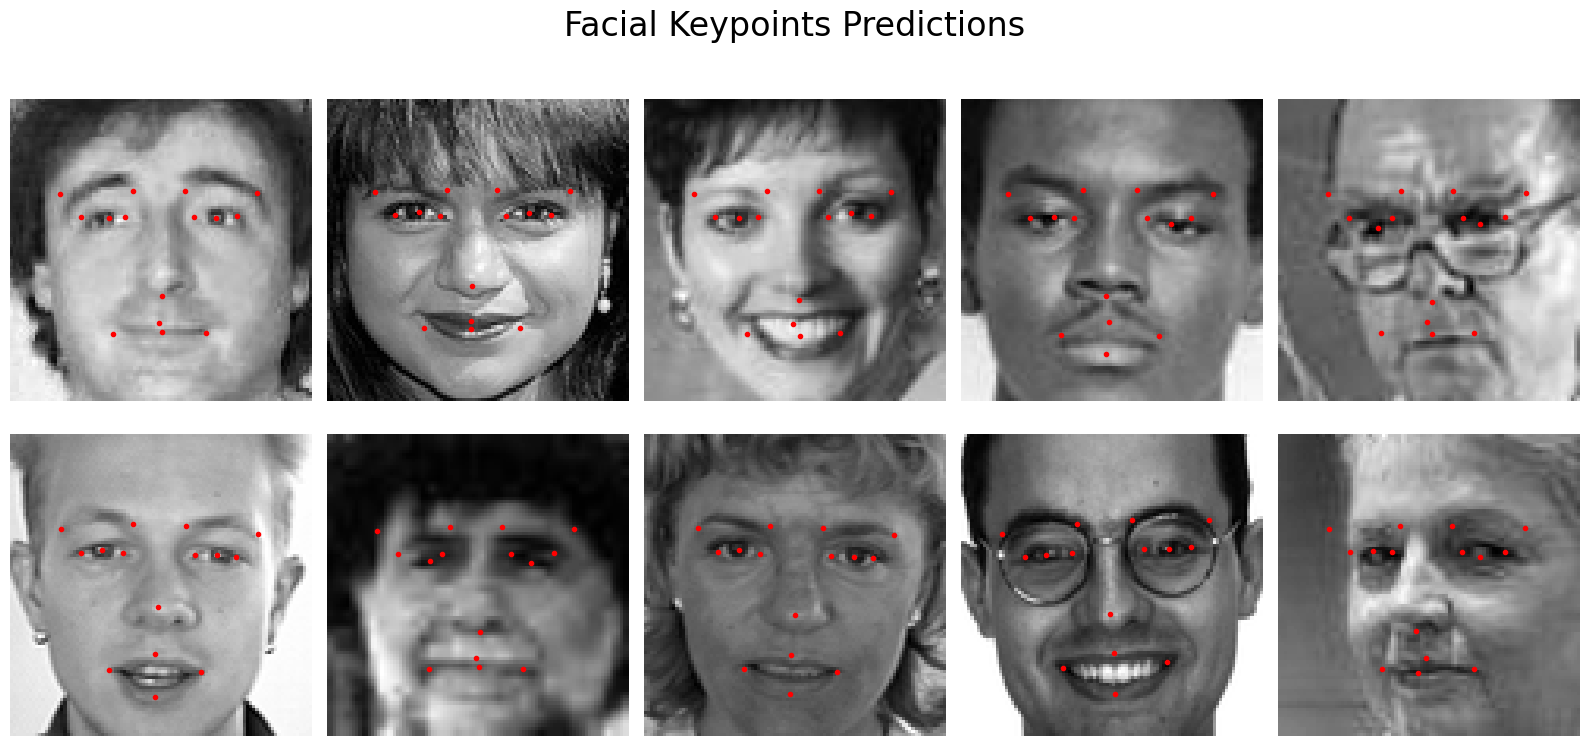

In [19]:
display_facial_keypoints_predictions(fkp_resnet50_trainer.model)

ResNet50 indeed is very powerful, with the same hyperparameters and epochs, it resulted in a better score than our custom model. I also noticed that although the initial loss is much larger in ResNet50, it converged and found the optimum much quicker, which is really fascinating.

**<h3>Create Submission CSV</h3>**

In [20]:
# def create_submission_csv(model, csv_name):
#     model = model.to(device)
#     model.eval()
#     fkp_cols = [c for c in df_train.columns if c != "Image"]
#     preds = []
#     for i in range(len(x_test)):
#         img_id = df_test.loc[i, "ImageId"]
#         img = torch.Tensor(x_test[i]).to(device).unsqueeze(0)
#         pred = model(img).cpu().detach().numpy()
#         pred = np.squeeze(pred)
#         pred = np.clip(pred, 0.0, 96.0)
#         for idx, col in enumerate(fkp_cols):
#             preds.append([img_id, col, pred[idx]])
#     df_preds = pd.DataFrame(preds, columns=["ImageId", "FeatureName", "Location"])
#     df_sub = pd.merge(df_id.drop("Location", axis=1), df_preds, how="left", on=["ImageId", "FeatureName"])
#     df_sub = df_sub[["RowId", "Location"]].reset_index(drop=True)
#     df_sub.to_csv(os.path.join(base_dir, csv_name) + ".csv", index=False)

# create_submission_csv(fkp_custom_cnn_trainer.model, "fkp_custom_cnn_tune3")
# create_submission_csv(fkp_resnet50_trainer.model, "fkp_resnet50")

**<h3>Conclusion</h3>**

Facial keypoints detection is widely used in the real life, and it is critical for facial recognition and many other applications. In this project, I learned more about PyTorch framework, built a custom CNN from scratch, learned how we can dynamically adjust learning rate for the optimizer, and how different hyperparameter values affect the model performance. In addition to that, I also learned about the famous residual neural network architecture (ResNet) and compared it against our custom model. Although ResNet resulted in a better score, and is more robust for general image processing tasks, I'm glad that I built a model from scratch that performs not much worse than ResNet for this particular problem : ).